# CSGY-6053: Foundations of Data Science Final Project

**Group Members**

Sam Geier (sg7849)

Simone Bookman (snb331)

Steven Granaturov (sg8002)

In [ ]:
from scipy import stats
import numpy as np
import seaborn as sns

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import pandas as pd
import math

# The Data


The dataset contains the count of public bicycles rented per hour in the Seoul Bike Sharing System along with corresponding weather data and holiday information. There are 8760 entries spanning from January 2017 - December 2018 with no missing values.

In [ ]:
df = pd.read_csv("/content/SeoulBikeData.csv", header = 0)

df.head()

,Date,Rented Bike Count,Hour,Temperature (Celcius),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature (Celcius),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Rows: 8760

Columns: 14
 - Date : year-month-day
 - Rented Bike count - Count of bikes rented at each hour
 - Hour - Hour of the day
 - Temperature-Temperature in Celsius
 - Humidity - %
 - Windspeed - m/s
 - Visibility - 10m
 - Dew point temperature - Celsius
 - Solar radiation - MJ/m2
 - Rainfall - mm
 - Snowfall - cm
 - Seasons - Winter, Spring, Summer Autumn
 - Holiday - Holiday/No holiday
 - Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

Source: https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

# Identify a Question/Estimand

How does time of day affect the number of bike rentals in Seoul, South Korea?

# Causal Model

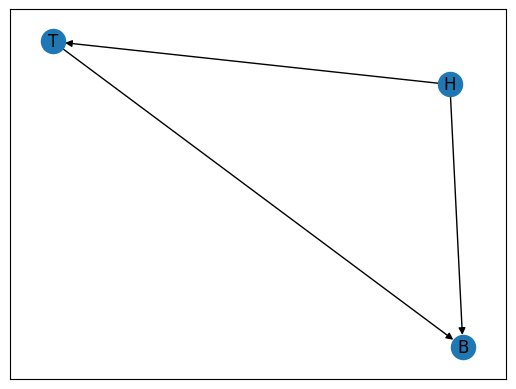

In [ ]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edges_from([("H", "T"), ("H", "B"), ("T", "B")])
plt.tight_layout()
nx.draw_networkx(graph, arrows=True)

H: Hour (time of day)

T: Temperature in Celsius

B: Number of bike rentals

# Prior predictive simulations

According to statista<sup>[1]</sup> , the average number of bikes rented in the Seoul public bike share rentals per day (in thousands) was 13.78 in 2017 and 27.57 in 2018. That comes out to about 1.72 bikes per hour over both years.

Since we are dealing with the number of occurrences of bike rentals over fixed intervals during the day, we chose a Poisson distribution. The Poisson distribution is best suited in this case because we could be dealing with a large maximum number of bike rides in an hour, and the number will always be positive.

[1]: https://www.statista.com/statistics/997380/south-korea-seoul-bike-daily-rental-number/

## Total Causal Effect Priors

#### Bad priors
$\mu \sim Normal(0,1)$

$\sigma \sim Exponential(1)$

$\alpha \sim Normal(\mu, \sigma)$

$λ = exp(\alpha)$

$R \sim Poisson(\lambda)$

In [ ]:
with pm.Model() as m_predictive_bad:
    a_mu = pm.Normal("a_mu", 0, 1)
    a_sig = pm.Exponential("a_sig", 1)

    a = pm.Normal("a", a_mu, a_sig)
    lam = pm.math.exp(a)
    R = pm.Poisson("rentals", lam)
    idata_predictive_bad = pm.sample_prior_predictive(random_seed=145)
az.summary(idata_predictive_bad)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_sig,0.950,0.984,0.001,2.770,0.044,0.031,464.0,332.0,NaN
rentals,13.482,163.055,0.000,11.000,7.239,5.138,514.0,463.0,NaN
a,0.132,1.675,-3.560,2.684,0.072,0.051,569.0,375.0,NaN
a_mu,0.072,0.996,-1.800,1.890,0.043,0.033,531.0,472.0,NaN


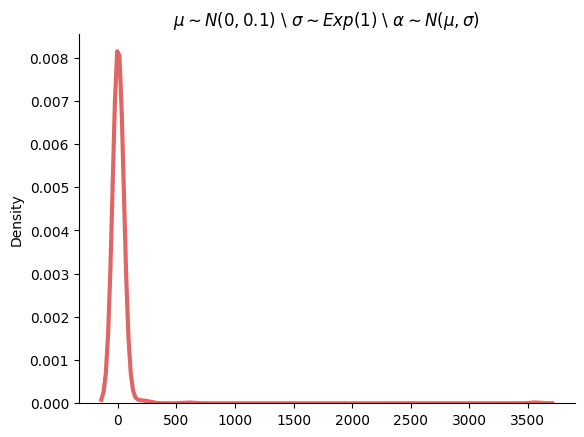

In [ ]:
rental_predictions = idata_predictive_bad.prior.rentals[0]

sns.kdeplot(rental_predictions, lw=3, color="#e06666")
plt.title(r"$\mu \sim N(0, 0.1)$ \ $\sigma \sim Exp(1)$ \ $\alpha \sim N(\mu, \sigma$)")
sns.despine();

These priors do not seem realistic. The average number of rentals is too low (around 13 when it should be closer to 1720) and the tail is too long.

#### Better Priors
$\mu \sim Normal(7.5,0.1)$

$\sigma \sim Exponential(0.3)$

$\alpha \sim Normal(\mu, \sigma)$

$log(λ) = \alpha$

$R \sim Poisson(\lambda)$

In [ ]:
with pm.Model() as m_predictive_better:
    a_mu = pm.Normal("a_mu", 7.5, 0.1)
    a_sig = pm.Exponential("a_sig", 30)        # same as scipy.stats.expon(.3)

    a = pm.Normal("a", a_mu, a_sig)
    lam = pm.math.exp(a)
    R = pm.Poisson("rentals", lam)
    idata_predictive_better = pm.sample_prior_predictive(random_seed=145)
az.summary(idata_predictive_better)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_sig,0.032,0.033,0.000,0.092,0.001,0.001,464.0,332.0,NaN
rentals,1832.130,202.413,1447.000,2209.000,8.650,6.159,547.0,513.0,NaN
a,7.509,0.109,7.296,7.708,0.005,0.003,549.0,472.0,NaN
a_mu,7.507,0.100,7.320,7.689,0.004,0.003,531.0,472.0,NaN


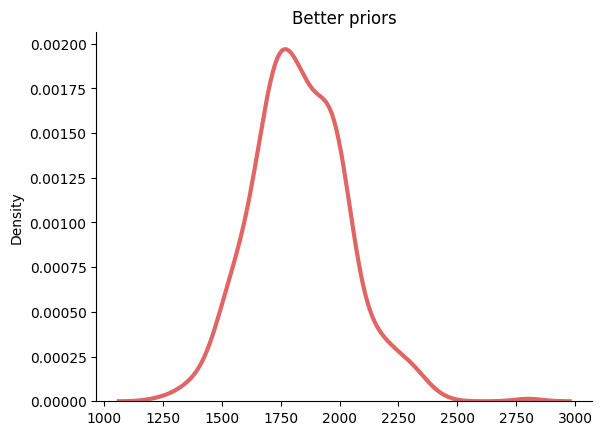

In [ ]:
rental_predictions = idata_predictive_better.prior.rentals[0]

sns.kdeplot(rental_predictions, lw=3, color="#e06666")
plt.title("Better priors")
sns.despine();

With these updated priors, the mean rentals is $\approx$1800 which is much closer to what we would expect.

The lower end of the distribution is around 1000 and upper end is around 3000, but the distribution is skewed slightly towards the lower end.

## Direct Causal Effect Priors




According to wikipedia, the average annual temperature in Seol is 12.8°C. The coldest and hotest months respectively are January (-1.9°C) and August(26.1°C)<sup>[2]</sup> so we estimate the standard deviation to be around 5.

$T \sim Normal(12.8, 5)$

[2]: https://en.wikipedia.org/wiki/Climate_of_Seoul#:~:text=The%20average%20annual%20temperature%20is,large%20with%2028.0%C2%B0C.



#### Data transformation on Tempurature

We don't think there is a linear relationship between tempurature and rentals. If the weather is nice out more people are likely to ride bikes than if it is really hot or really cold.

According to "Big Momma's Bicycles" 60 to 80 degrees Farenheit (15-27 Celsius) is what most cyclists would call ideal cycling weather<sup>[1]</sup>.

We applied to following data transformation so that tempurature could be added to the model as a linear term.

$$T\_transformed = \frac{1500 - (18 - T)^2}{1000}$$
 - 1500 so that most if not all values fall above 0
 - 18 is our estimation of the ideal tempurature for cycling
 - 1000 is a scaling factor so that $\beta$ can be on the same scale as the $\alpha$ value.

[1]:https://bigmommasbicycles.com/2022/01/the-best-weather-conditions-to-ride-a-bicycle/#:~:text=While%20high%20temps%20aren't,bike%20slices%20through%20the%20wind.


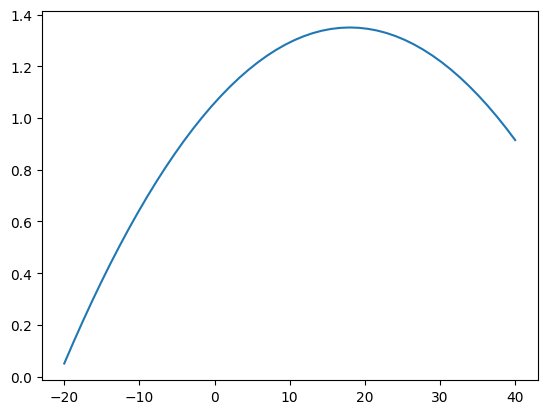

In [ ]:
def transform_tempurature(t):
  temp_offset = 1500
  good_temp = 18
  return (temp_offset-(good_temp-temp)**2) /1000

beta = .9
temp = np.linspace(-20, 40)
trans = transform_tempurature(temp)
plt.plot(temp, beta*trans)

Adding tempurature to our previous model:

$\mu_\alpha \sim Normal(6,0.1)$

$\sigma_\alpha \sim Exponential(0.3)$

$\alpha \sim Normal(\mu_\alpha, \sigma_\alpha)$

$\mu_\beta \sim Normal(1, 0.1)$

$\sigma_\beta \sim Exponential(0.3)$

$\beta \sim Normal(\mu_\beta, \sigma_\beta)$

$log(λ) = \alpha + \beta * T\_transformed$

$R \sim Poisson(\lambda)$


In [ ]:
with pm.Model() as m_predictive_direct:
    a_mu = pm.Normal("a_mu", 6, .1)
    a_sig = pm.Exponential("a_sig", 30)        # same as scipy.stats.expon(.03)

    b_mu = pm.Normal("b_mu", 1, .1)
    b_sig = pm.Exponential("b_sig", 30)

    T = pm.Normal("T", 12.8, 5)
    T_transform = (1500 - (18 - T)**2) /1000

    a = pm.Normal("a", a_mu, a_sig)
    b = pm.Normal("b", b_mu, b_sig)
    lam = pm.math.exp(a + b*T_transform)
    R = pm.Poisson("rentals", lam)
    idata_predictive_direct = pm.sample_prior_predictive(random_seed=145)
az.summary(idata_predictive_direct)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rentals,1780.556,365.483,1174.000,2447.000,16.259,11.503,490.0,456.0,NaN
T,12.897,5.147,3.326,21.516,0.247,0.175,444.0,455.0,NaN
b_sig,0.030,0.029,0.000,0.085,0.001,0.001,456.0,468.0,NaN
b_mu,1.008,0.098,0.813,1.171,0.005,0.003,462.0,409.0,NaN
a_mu,6.007,0.100,5.820,6.189,0.004,0.003,531.0,472.0,NaN
a,6.009,0.109,5.796,6.208,0.005,0.003,549.0,472.0,NaN
a_sig,0.032,0.033,0.000,0.092,0.001,0.001,464.0,332.0,NaN
b,1.007,0.107,0.816,1.207,0.005,0.004,443.0,437.0,NaN


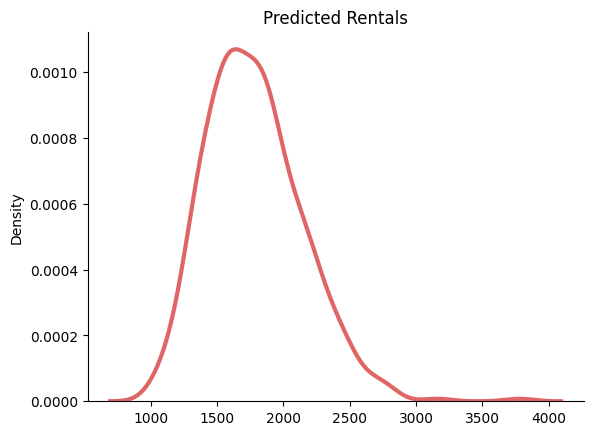

In [ ]:
rental_predictions = idata_predictive_direct.prior.rentals[0]

sns.kdeplot(rental_predictions, lw=3, color="#e06666")
plt.title(r"Predicted Rentals")
sns.despine();

Here again, we have mean rentals close to 1720 (~1780). The miniumum value is around 1000 rentals per hour and we maintain a resonable tail on the right side.

# Simulating Data

For the total causal relationship each $\alpha_i$ comes from a normal distribution paramaterized by $\mu$ and $\sigma$. We then gather the relevant alpha, mu and sigma values to cross reference against the mean values returned from running the simulated model. For each of the 4 hours we use the corresponding $\alpha_i$ to simulate 1000 rental amounts (representing 1000 days of rentals).

Our simulated direct causal relationship replicates the majority of the above, but adds on a normally distributed beta value which is paramaterized by a separate $\mu$ and $\sigma$. The underlying temperatures that we feed into the test model go through our temperature transformation discussed abover. We transform the temperature in order to reflect the understanding that the relationship between temp and the number of rentals isn't linear.

In terms of what we can draw from the results of our model being run on our simulated data, we can see that the total causal relationship does show that certain times in our four hour sample tend to see more ridership than the rest. Specifically hours 0 and 3 have larger mean values, implying higher ridership at those particular hours.

For the direct causal relationship we get slightly different results, with our alpha values being nearly identical at each of the four simulated hours. The difference could mean that temperature has more of an impact on the number of rides than initially anticipated.

#### Total Causal Effect
$\mu \sim Normal(7.5,0.1)$

$\sigma \sim Exponential(0.3)$

$\alpha_i \sim Normal(\mu, \sigma)$

$log(λ_i) = \alpha_i$

$R_i \sim Poisson(\lambda_i)$

Note: i indexes the hours

In [ ]:
# Total causal effect
num_days = 1000
num_hours = 4

mu_alpha = np.random.normal(7.5, 0.1)
sigma_alpha = np.random.exponential(0.3)
alpha = np.random.normal(mu_alpha, sigma_alpha, size=num_hours)
lmda = np.exp(alpha)

rentals = np.random.poisson(lmda, size=(num_days, num_hours))
rentals_flat = rentals.flatten()

rid = np.array(list(range(4))*num_days)
# rid: array([0,1,2,3,1,2,3,...]) representing which hour the sample belongs to

print(f"mu \t\t{mu_alpha}")
for i in range(4):
  print(f"alpha[{i}]\t{alpha[i]}")
print(f"sigma \t\t{sigma_alpha}")

mu 		7.380160746333967
alpha[0]	7.445853630401227
alpha[1]	7.465437522383791
alpha[2]	7.157787150482544
alpha[3]	7.314082139364814
sigma 		0.16681174205246735


In [ ]:
with pm.Model() as m_total_simulated:
    a_mu = pm.Normal("a_mu", .7, .01)
    a_sig = pm.Exponential("a_sig", 7)

    a = pm.Normal("a", a_mu, a_sig, shape=num_hours)
    lam = pm.math.exp(a[rid])
    R = pm.Poisson("rentals", lam, observed=rentals_flat)
    idata_total_simulated = pm.sample(
                    tune=3000,
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )

az.summary(idata_total_simulated)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,0.700,0.010,0.681,0.717,0.000,0.000,2886.0,1659.0,1.0
a[0],7.446,0.001,7.445,7.448,0.000,0.000,2699.0,1608.0,1.0
a[1],7.466,0.001,7.465,7.468,0.000,0.000,2917.0,1399.0,1.0
a[2],7.158,0.001,7.157,7.160,0.000,0.000,3070.0,1805.0,1.0
a[3],7.314,0.001,7.313,7.316,0.000,0.000,2488.0,1678.0,1.0
a_sig,2.840,0.354,2.210,3.519,0.006,0.004,3511.0,1444.0,1.0


#### Direct Causal Effect

$\mu_\alpha \sim Normal(6,0.1)$

$\sigma_\alpha \sim Exponential(0.3)$

$\alpha_i \sim Normal(\mu_\alpha, \sigma_\alpha)$

$\mu_\beta \sim Normal(1,0.1)$

$\sigma_\beta \sim Exponential(0.3)$

$\beta_i \sim Normal(\mu_\beta, \sigma_\beta)$

$T \sim Normal(12.8, 5)$

$log(λ) = alpha_i + \beta_i * T\_transformed_i$

$R \sim Poisson(\lambda)$

In [ ]:
num_days = 1000
num_hours = 4

mu_alpha = np.random.normal(6, 0.1)
sigma_alpha = np.random.exponential(0.3)
alpha = np.random.normal(mu_alpha, sigma_alpha, size=num_hours)

mu_beta = np.random.normal(1, 0.1)
sigma_beta = np.random.exponential(.3)
beta = np.random.normal(mu_beta, sigma_beta, size=num_hours)

temp = np.random.normal(12.8, 5, size=(num_days, num_hours))
temp_transform = transform_tempurature(temp)

lmda = np.exp(alpha + beta*(temp_transform))

rentals = np.random.poisson(lmda, size=(num_days, num_hours))

rid = np.array(list(range(num_hours))*num_days)

print(f"mu alpha \t{mu_alpha}")
print(f"mu beta \t{mu_beta}")
print(f"alpha \t{alpha}")
print(f"beta \t{beta}")
print(f"sigma alpha \t{sigma_alpha}")
print(f"sigma beta \t{sigma_beta}")

mu alpha 	5.993391373546603
mu beta 	1.070945644379399
alpha 	[5.94940207 6.93212651 5.69731129 5.60378833]
beta 	[1.05878958 0.70092284 2.13344801 0.41412064]
sigma alpha 	0.4640578191895266
sigma beta 	0.4653134475338354


In [ ]:
Yetemps_flat = temp_transform.flatten()
rentals_flat = rentals.flatten()

with pm.Model() as m_direct_simulated:
    a_mu = pm.Normal("a_mu", 6, .1)
    a_sig = pm.Exponential("a_sig", 30)

    b_mu = pm.Normal("b_mu", 1, 0.1)
    b_sig = pm.Exponential("b_sig", 30)

    a = pm.Normal("a", a_mu, a_sig, shape=num_hours)
    b = pm.Normal("b", b_mu, b_sig, shape=num_hours)
    lam = pm.math.exp(a[rid] + b[rid]*(temps_flat[rid]))
    R = pm.Poisson("rentals", lam, observed=rentals_flat)
    idata_direct_simulated = pm.sample(
                    tune=3000,
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )

az.summary(idata_direct_simulated)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,6.018,0.093,5.846,6.195,0.005,0.003,376.0,527.0,1.01
b_mu,1.028,0.087,0.867,1.192,0.003,0.002,1135.0,1170.0,1.01
a[0],6.023,0.105,5.828,6.219,0.005,0.004,398.0,600.0,1.01
a[1],6.022,0.110,5.827,6.226,0.005,0.004,414.0,593.0,1.01
a[2],6.033,0.113,5.828,6.242,0.006,0.004,375.0,487.0,1.01
a[3],6.002,0.112,5.811,6.217,0.006,0.004,383.0,387.0,1.00
b[0],1.208,0.086,1.047,1.368,0.004,0.003,398.0,596.0,1.01
b[1],1.290,0.074,1.153,1.419,0.003,0.002,414.0,582.0,1.01
b[2],1.857,0.076,1.717,1.995,0.004,0.003,374.0,485.0,1.01
b[3],0.134,0.075,-0.014,0.259,0.004,0.003,383.0,378.0,1.00


# Analyze the Real Data

In [ ]:
num_days = int(df.shape[0]/24)
num_hours = 24

rentals = df["Rented Bike Count"]
temps = df["Temperature (Celcius)"]

rid_real = np.array(list(range(num_hours))*num_days)

#### Total Causal Effect

Explaining the results of the total causal effect.

$\mu \sim Normal(7.5,0.1)$

$\sigma \sim Exponential(0.3)$

$\alpha_i \sim Normal(\mu, \sigma)$

$log(λ_i) = \alpha_i$

$R_i \sim Poisson(\lambda_i)$

Note: i indexes the hours

-

In [ ]:
with pm.Model() as m_total:
    a_mu = pm.Normal("a_mu", 7.5, .1)
    a_sig = pm.Exponential("a_sig", 30)

    a = pm.Normal("a", a_mu, a_sig, shape=num_hours)
    lam = pm.math.exp(a[rid_real])
    R = pm.Poisson("rentals", lam, observed=rentals)
    idata_total = pm.sample(
                    tune=3000,
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )

az.summary(idata_total)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,7.158,0.095,6.986,7.344,0.002,0.001,3819.0,1536.0,1.00
a[0],6.294,0.002,6.290,6.298,0.000,0.000,5870.0,1528.0,1.00
a[1],6.055,0.003,6.050,6.059,0.000,0.000,5146.0,1521.0,1.00
a[2],5.709,0.003,5.704,5.715,0.000,0.000,4971.0,1495.0,1.00
a[3],5.315,0.004,5.308,5.322,0.000,0.000,5785.0,1314.0,1.00
a[4],4.887,0.005,4.879,4.896,0.000,0.000,6066.0,1399.0,1.00
a[5],4.935,0.005,4.926,4.943,0.000,0.000,4583.0,1316.0,1.00
a[6],5.661,0.003,5.656,5.668,0.000,0.000,6281.0,1428.0,1.00
a[7],6.407,0.002,6.403,6.411,0.000,0.000,5204.0,1494.0,1.01
a[8],6.923,0.002,6.920,6.926,0.000,0.000,6602.0,1281.0,1.00


- $a_\mu$: Estimated to be around 7.158
- $a_\sigma$: Estimated to be around 0.741 which indicates moderate variability
- $\hat{R}$: Most values are 1.00 which indicates a good convergence.
- a[i] references the mean, standard deviation, and the HDI for each hour
- The overall narrow HDI for $a_\mu$ and moderate $a_\sigma$ indicate a reasonably confident estimate for the overall mean and deviation.
- There is a peak at a[8] (8:00AM) and a[18] (6:00PM). We think these peaks are due to people commuting to and from work using the bike share rentals.

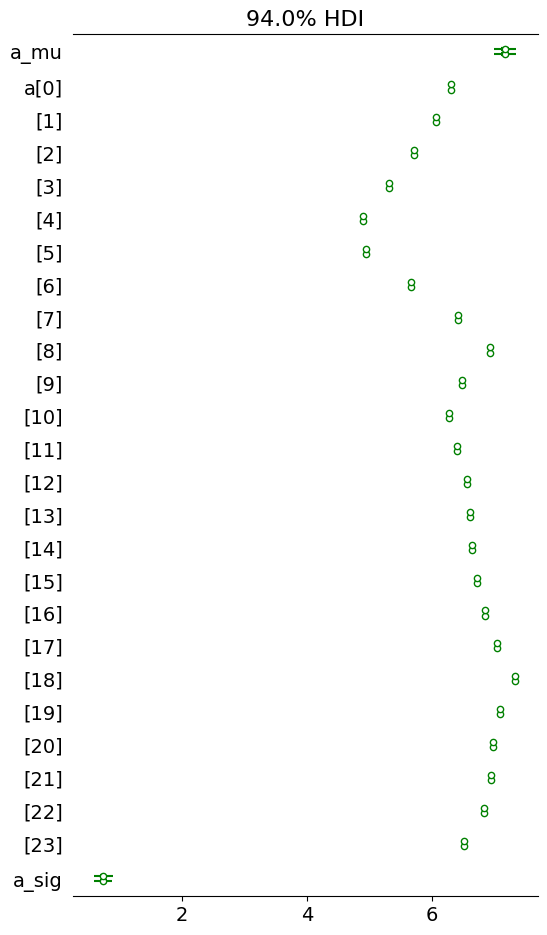

In [ ]:
_ = az.plot_forest(idata_total, colors='g')

Text(0, 0.5, 'Intercept')

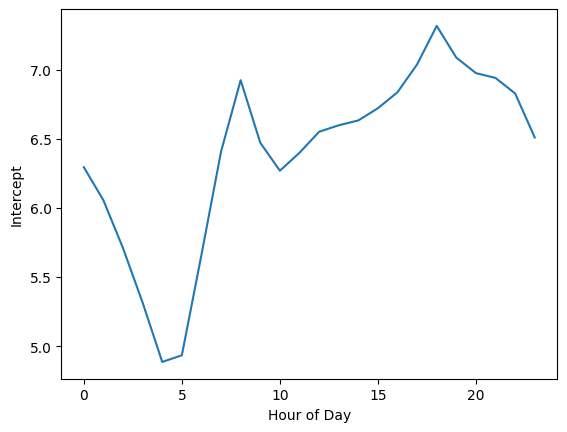

In [ ]:
h = np.arange(24)
post_alphas_tot = az.summary(idata_total, var_names=["a"])['mean']

plt.plot(h, post_alphas_tot)
plt.xlabel('Hour of Day')
plt.ylabel('Intercept')

- The predicted intercept follows the same shape as our assumptions
- The peak at 6:00pm when compared to the one at 8:00am isn't as huge as expected
  - Could be because the model believes the 6:00 peak is an outlier or, there is another underlying cause that we didn't consider
- There's a steep drop after 11:00pm which is probably because most people are home for the night after that time.

#### Direct Causal Effect

Explaining the results of the direct causal effect.

In [ ]:
# temps_transformed = transform_tempurature(temps)    # giving strange behaviour?
temps_transformed = (1500-(18-temps)**2) /1000

with pm.Model() as m_direct:
    a_mu = pm.Normal("a_mu", 6, .1)
    a_sig = pm.Exponential("a_sig", 30)

    b_mu = pm.Normal("b_mu", 1, 0.1)
    b_sig = pm.Exponential("b_sig", 30)

    a = pm.Normal("a", a_mu, a_sig, shape=num_hours)
    b = pm.Normal("b", b_mu, b_sig, shape=num_hours)
    lam = pm.math.exp(a[rid_real] + b[rid_real]*(temps_transformed[rid_real]))
    R = pm.Poisson("rentals", lam, observed=rentals)
    idata_direct = pm.sample(
                    tune=3000,
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )

az.summary(idata_direct)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu,5.784,0.082,5.634,5.941,0.005,0.004,269.0,798.0,1.00
b_mu,0.792,0.078,0.656,0.947,0.009,0.007,69.0,168.0,1.03
a[0],5.535,0.092,5.353,5.704,0.009,0.006,97.0,234.0,1.02
a[1],5.311,0.087,5.146,5.473,0.009,0.006,93.0,266.0,1.02
a[2],4.988,0.092,4.813,5.147,0.010,0.007,86.0,247.0,1.02
a[3],4.602,0.090,4.429,4.756,0.009,0.006,91.0,245.0,1.02
a[4],4.172,0.098,4.000,4.338,0.010,0.007,87.0,221.0,1.02
a[5],4.234,0.092,4.065,4.394,0.009,0.006,89.0,251.0,1.02
a[6],4.961,0.089,4.797,5.126,0.008,0.006,106.0,337.0,1.02
a[7],5.732,0.081,5.577,5.881,0.008,0.006,91.0,343.0,1.03


- $a_\mu$: Estimated to be around 5.784
- $a_\sigma$: Estimated to be around 0.082
- $\hat{R}$: Most values are 1.03 which indicates a good convergence.
- a[i] and b[i] references the mean, standard deviation, and the HDI for each hour where alpha is the time of day and beta is the temperature
- Again as expected, there is a peak at a[8] (8:00AM) and a[18] (6:00PM) which supports our analysis of there being 2 peaks, one in the morning commute, and one in the evening commute
- The overall narrow HDI for $a_\mu$ and moderate $a_\sigma$ indicate a reasonably confident estimate for the overall mean and deviation.
- $b[i]$ values are relatively low, and don't fluctuate much indicating that temperature doesn't really affect bike rentals at a given time

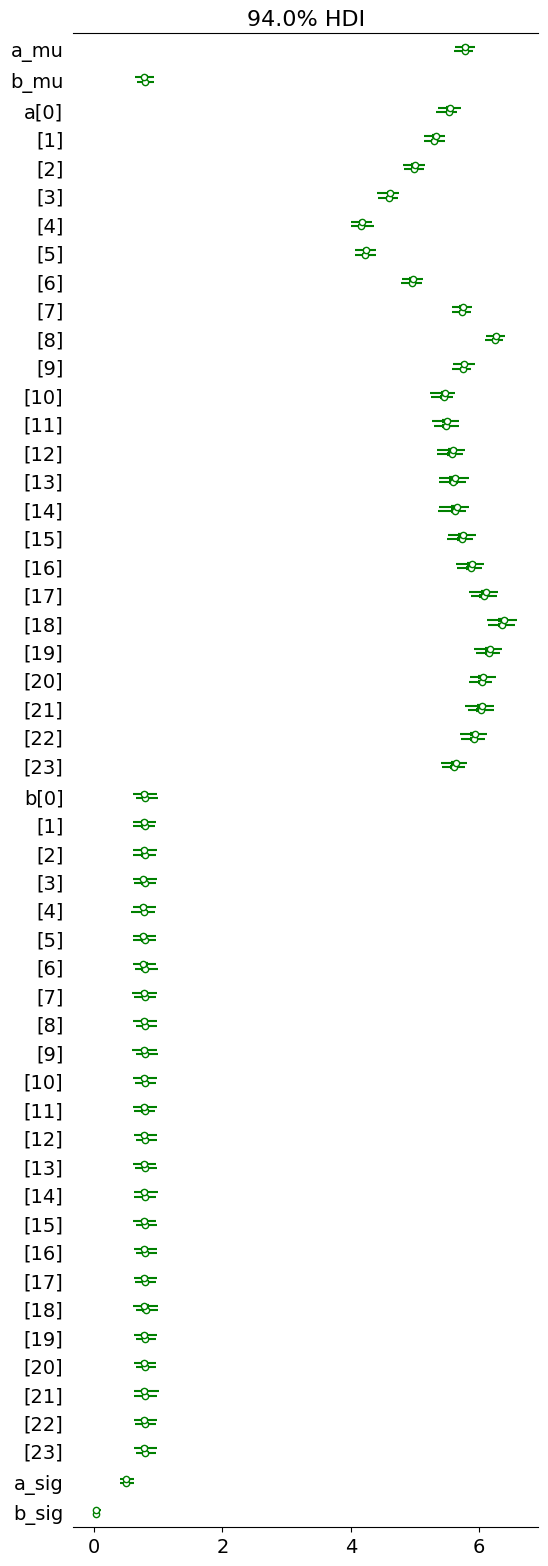

In [ ]:
_ = az.plot_forest(idata_direct, colors='g')

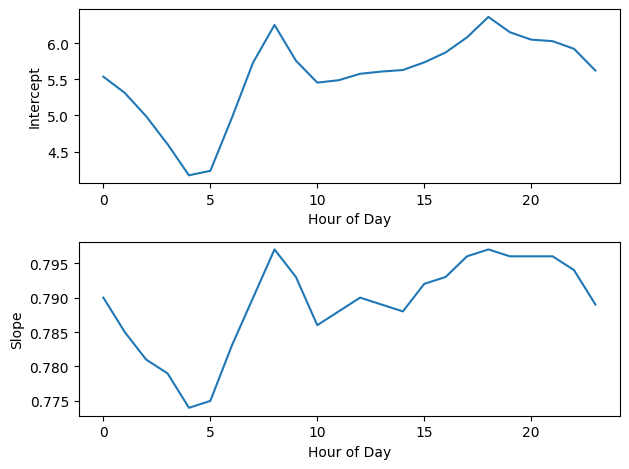

In [ ]:
h = np.arange(24)
post_alphas_dir = az.summary(idata_direct, var_names=["a"])['mean']
post_betas_dir = az.summary(idata_direct, var_names=["b"])['mean']

plt.subplot(2, 1, 1)
plt.plot(h, post_alphas_dir)
plt.xlabel('Hour of Day')
plt.ylabel('Intercept')

# Plot for second_value = 1
plt.subplot(2, 1, 2)
plt.plot(h, post_betas_dir)
plt.xlabel('Hour of Day')
plt.ylabel('Slope')

plt.tight_layout()
plt.show()

$log(λ) = alpha_i + \beta_i * T$

The top graph represents the predicted $a$ values and the bottom graph represents the predicted $b$ values at a given hour.

The trend in $b$ values matches the $a$ values trend pretty closely, but the scale is different. $a$ ranges from 4.0 to 6.5 -- a range of 2.5. $b$ ranges from 0.770 to 0.800 -- a range of 0.030. This supports our analysis that hour is the driving factor and that temp doesn't really have much of an effect.

#### Underlying Data

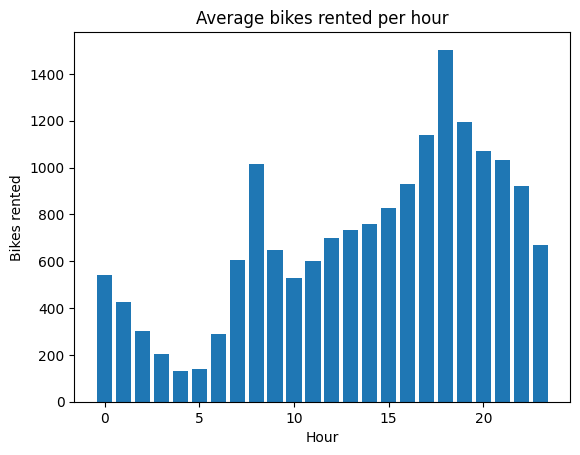

In [ ]:
data_copy = df.copy()

vals1, data_copy['Seasons'] = np.unique(data_copy['Seasons'].values, return_inverse=True)
vals2, data_copy['Holiday'] = np.unique(data_copy['Holiday'].values, return_inverse=True)
vals3, data_copy['Functioning Day'] = np.unique(data_copy['Functioning Day'].values, return_inverse=True)

data_copy.head()

data_format = data_copy.iloc[:, 1:]
data_format.head(25)

hourly_sum = []
for i in range(0, 24):
    data_hourly = data_format[data_format["Hour"] == i]
    sum = data_hourly['Rented Bike Count'].sum() / num_days
    hourly_sum.append(sum)

plt.bar(np.arange(0, 24), hourly_sum)
plt.xlabel("Hour")
plt.ylabel("Bikes rented")
plt.title("Average bikes rented per hour")

plt.show()

Our analysis is supported by the data in the sense that there is indeed a morning peak for the morning commute and one for the evening. These are often considered to be "rush hours" where people commute the most.

In [ ]:
for row, index in data_copy.iterrows():
    data_copy.at[row, 'Temperature (Celcius)'] = math.floor(data_copy.at[row, 'Temperature (Celcius)'])

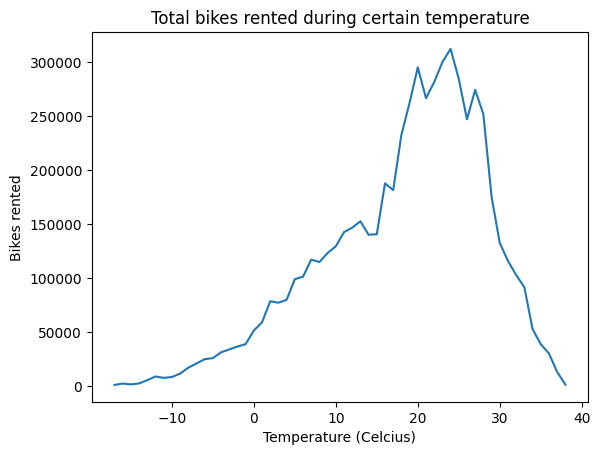

In [ ]:
temps = np.arange(-17, 39)

temp_sum = []
for i in range(len(temps)):
    data_temp = data_copy[data_copy['Temperature (Celcius)'] == temps[i]]
    sum = data_temp['Rented Bike Count'].sum()
    temp_sum.append(sum)

plt.plot(np.arange(-17, 39), temp_sum)
plt.xlabel("Temperature (Celcius)")
plt.ylabel("Bikes rented")
plt.title("Total bikes rented during certain temperature")

plt.show()

Temperature plays a small role in the number of bike rentals, especially when there is a massive interval. During the warmer months, people are more inclined to ride their bikes in comparison to the colder months, and it drops off during extreme heat. However, the temperature affects the average number of bikes rented but the overall distribution remains the same. Moreover, the time of day also impacts the temperature where the temperature typically rises into the afternoon and starts to decline in the late afternoon.

Works Cited:
- Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.